# Target
Comparison of standard PyTorch optimizers with various modifications of the new optimizer when training a simple neural network

## libraries

In [6]:
import os
# change the current working directory
os.chdir('..')

# main
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import R2Score

# graphics
import matplotlib.pyplot as plt

# implementation
from tools import make_regression_data, RegressionDataset,\
                  standard_training, drem_opt_training, plot_results, finite_time_opt_training
from optimizers import DREMOptimizer, FiniteTimeOptimizer

torch.random.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

In [14]:
NUMBER_OF_FEATURES = 10
X_train, X_test, y_train, y_test = make_regression_data(number_samples=100,
                                                        number_features=NUMBER_OF_FEATURES,
                                                        noise_value=5.5)
print(f'shape of train: {X_train.shape, y_train.shape}\nshape of test: {X_test.shape, y_test.shape}')

shape of train: (torch.Size([80, 10]), torch.Size([80, 1]))
shape of test: (torch.Size([20, 10]), torch.Size([20, 1]))


In [15]:
train_dataset = RegressionDataset(features=X_train,
                                  labels=y_train)
test_dataset = RegressionDataset(features=X_test,
                                 labels=y_test)
print(f'example of train sample:\n {train_dataset[19]}')

example of train sample:
 (tensor([-0.5173, -0.5229,  1.5796,  2.2989,  1.4534, -0.3628, -0.2818,  1.4093,
        -0.4455, -0.4202]), tensor([185.5551]))


In [17]:
BATCH_SIZE = 10

train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE)
batch_example_features, batch_example_labels  = next(iter(train_dataloader))
print('shape of batch: features - {} and labels - {}'.format(batch_example_features.shape, batch_example_labels.shape))

shape of batch: features - torch.Size([10, 10]) and labels - torch.Size([10, 1])


## Optimizers & loss function & metric

In [18]:
loss_fn = nn.MSELoss()

metric_fn = R2Score()

## 1. Simple perceptron


## 1.1 Adam optimizer
Firstly, we train 1-layer perceptron with Adam optimizer (learning rate = 0.1) and try to achieve **R2-score=0.95**

In [20]:
simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=1, bias=False))

# how many epochs we need to achieve 0.95 score?
n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.Adam,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.1,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 58880.180 and score = 0.015
epoch 2: loss = 57877.566 and score = 0.031
epoch 3: loss = 56909.094 and score = 0.048
epoch 4: loss = 55970.125 and score = 0.063
epoch 5: loss = 54998.070 and score = 0.080
epoch 6: loss = 53995.246 and score = 0.096
epoch 7: loss = 53046.141 and score = 0.112
epoch 8: loss = 52098.277 and score = 0.128
epoch 9: loss = 51162.016 and score = 0.144
epoch 10: loss = 50225.215 and score = 0.159
epoch 11: loss = 49304.137 and score = 0.175
epoch 12: loss = 48405.242 and score = 0.189
epoch 13: loss = 47531.457 and score = 0.204
epoch 14: loss = 46637.219 and score = 0.219
epoch 15: loss = 45760.914 and score = 0.234
epoch 16: loss = 44867.820 and score = 0.249
epoch 17: loss = 44048.922 and score = 0.262
epoch 18: loss = 43199.480 and score = 0.276
epoch 19: loss = 42371.797 and score = 0.290
epoch 20: loss = 41512.047 and score = 0.304
epoch 21: loss = 40734.621 and score = 0.317
epoch 22: loss = 39954.574 and score = 0.330
epoch 23: loss = 39

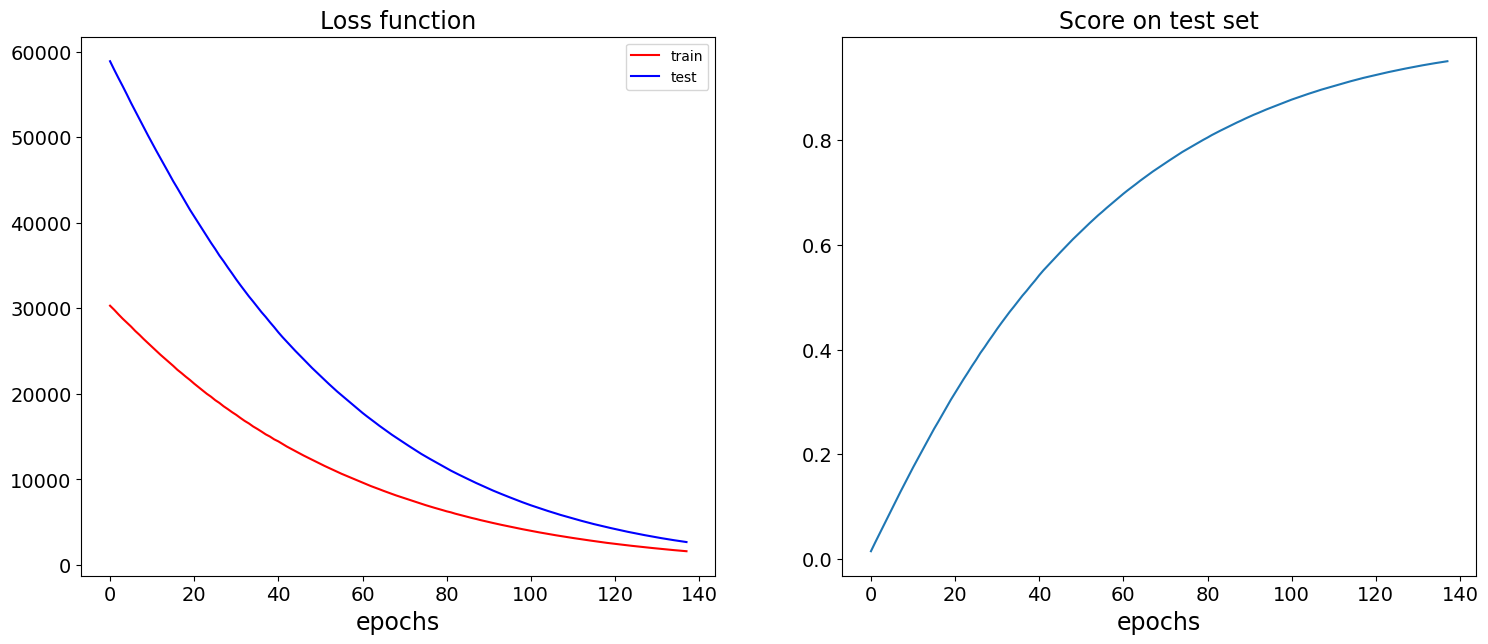

In [21]:
plot_results(train_loss, test_loss, test_score)

Secondly, we train 1-layer perceptron with Adam optimizer (learning rate = 0.1) **for 100 epochs**

In [22]:
simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=1, bias=False))

train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                      optimizer_fn=optim.Adam,
                                                      loss_fn=loss_fn,
                                                      metric_fn=metric_fn,
                                                      data_train=train_dataloader,
                                                      data_test=test_dataloader,
                                                      learning_rate=0.1,
                                                      epochs=100,
                                                      current_device=device)

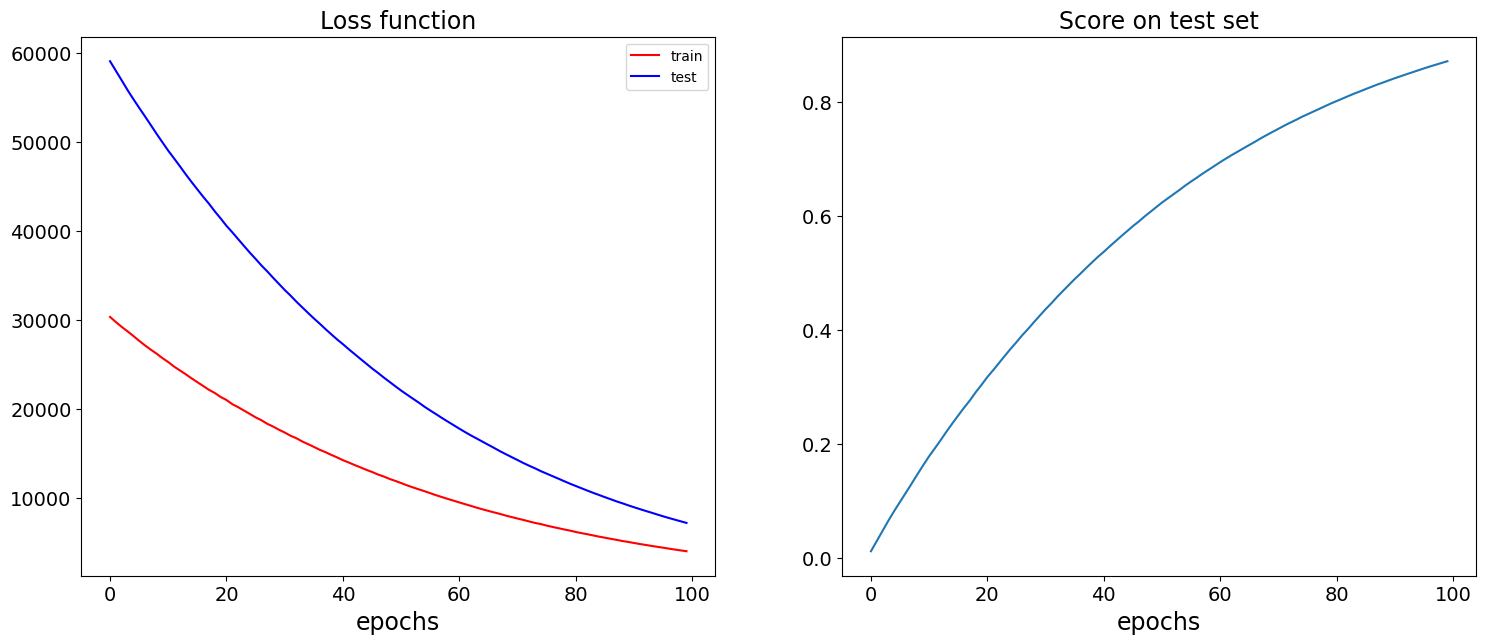

In [23]:
plot_results(train_loss, test_loss, test_score)

## 1.2 SGD optimizer
Train 1-layer perceptron with SGD optimizer (learning rate = 0.01) and try to achieve **R2-score=0.95**

In [24]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

# how many epochs we need to achieve 0.95 score?
n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.SGD,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.01,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 44000.051 and score = 0.267
epoch 2: loss = 32427.176 and score = 0.462
epoch 3: loss = 23989.699 and score = 0.603
epoch 4: loss = 17873.234 and score = 0.705
epoch 5: loss = 13372.755 and score = 0.780
epoch 6: loss = 10048.808 and score = 0.835
epoch 7: loss = 7592.692 and score = 0.875
epoch 8: loss = 5768.097 and score = 0.905
epoch 9: loss = 4405.169 and score = 0.927
epoch 10: loss = 3379.218 and score = 0.944
epoch 11: loss = 2599.817 and score = 0.957


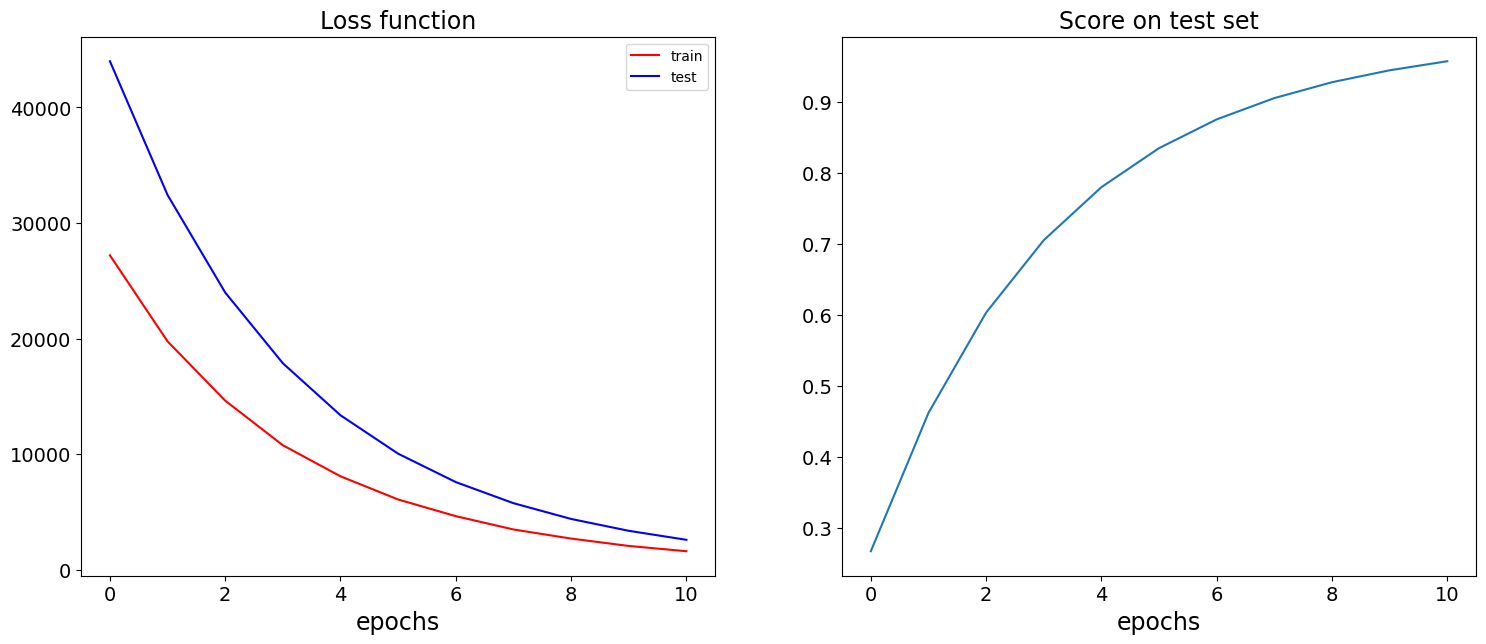

In [25]:
plot_results(train_loss, test_loss, test_score)

Train 1-layer perceptron with SGD optimizer (learning rate = 0.01) **for 100 epochs**

In [26]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                      optimizer_fn=optim.SGD,
                                                      loss_fn=loss_fn,
                                                      metric_fn=metric_fn,
                                                      data_train=train_dataloader,
                                                      data_test=test_dataloader,
                                                      learning_rate=0.01,
                                                      epochs=100,
                                                      current_device=device)

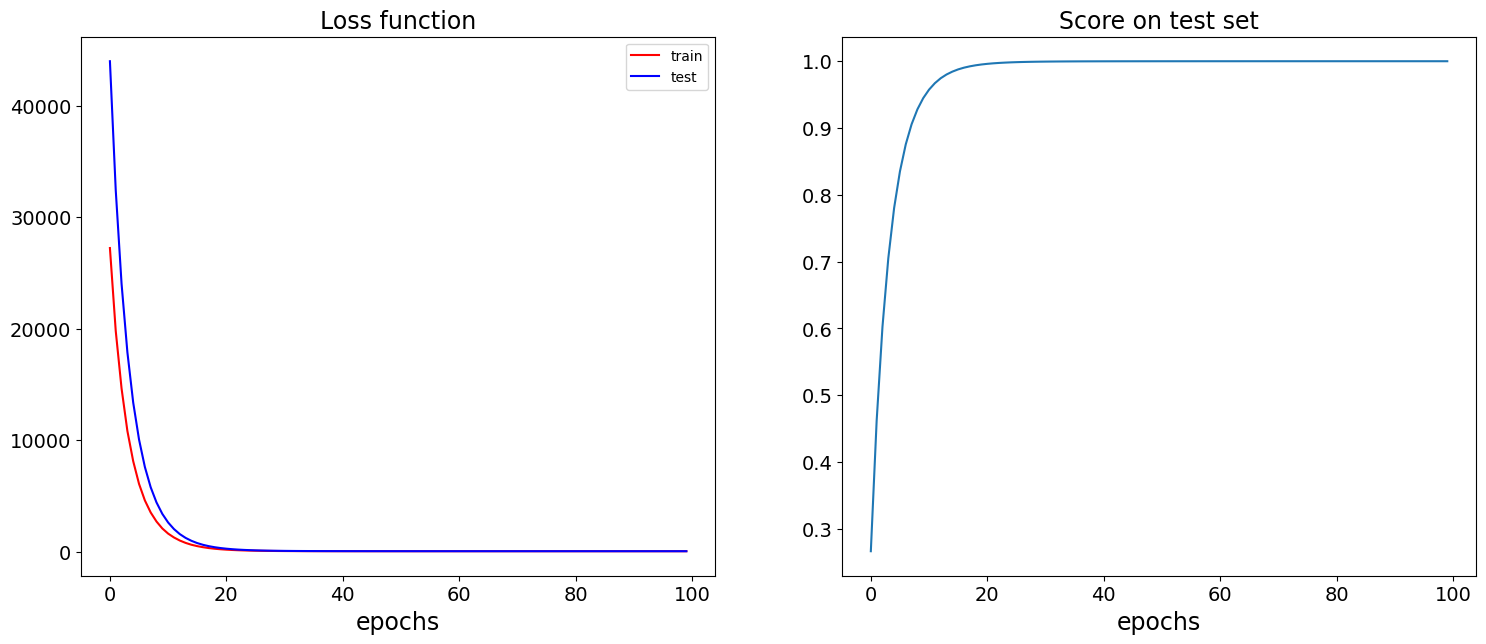

In [27]:
plot_results(train_loss, test_loss, test_score)

## 1.3 DREM optimizer
Train 1-layer perceptron with DREM optimizer (learning rate = 0.01) and try to achieve **R2-score=0.95**

In [28]:
simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=1, bias=False))

n_epochs, train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                                optimizer_fn=DREMOptimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.01,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 3152.344 and score = 0.937
epoch 2: loss = 308.099 and score = 0.994


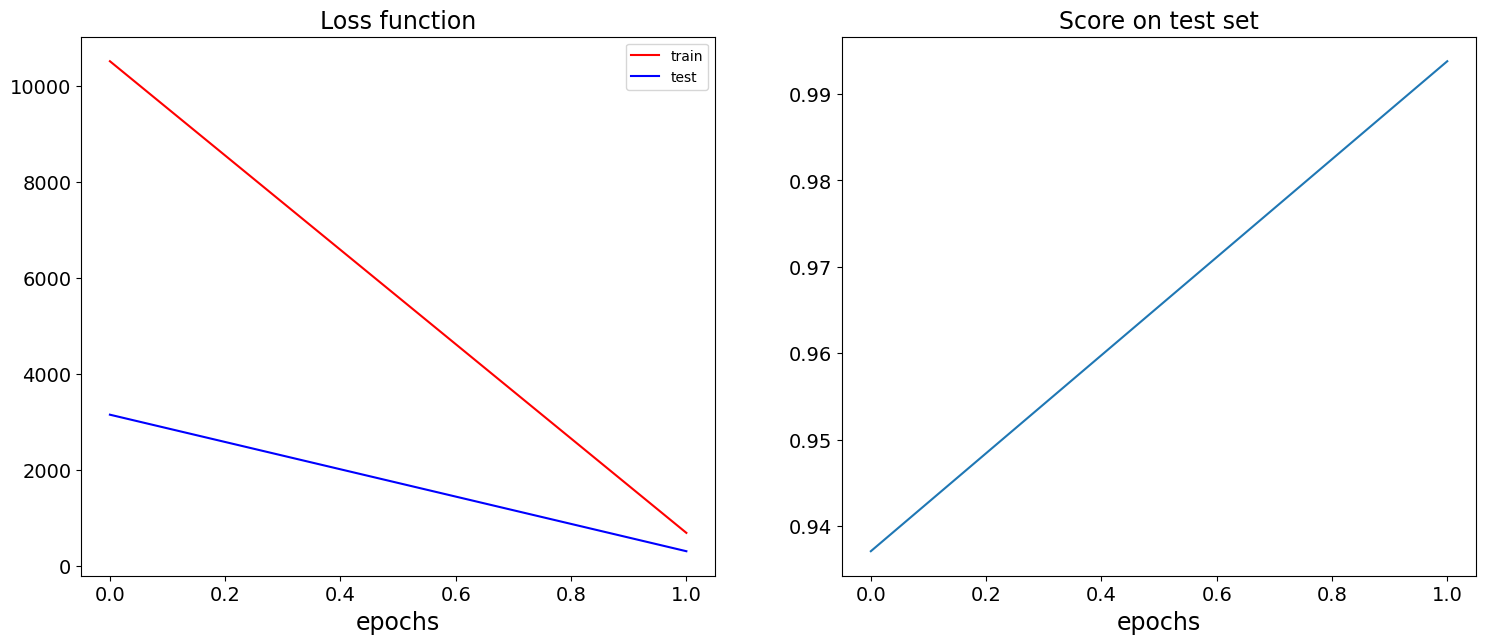

In [29]:
plot_results(train_loss, test_loss, test_score)

Train 1-layer perceptron with DREM optimizer (learning rate = 0.01) **for 100 epochs**

In [30]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                      optimizer_fn=DREMOptimizer,
                                                      loss_fn=loss_fn,
                                                      metric_fn=metric_fn,
                                                      data_train=train_dataloader,
                                                      data_test=test_dataloader,
                                                      learning_rate=0.01,
                                                      epochs=100,
                                                      current_device=device)

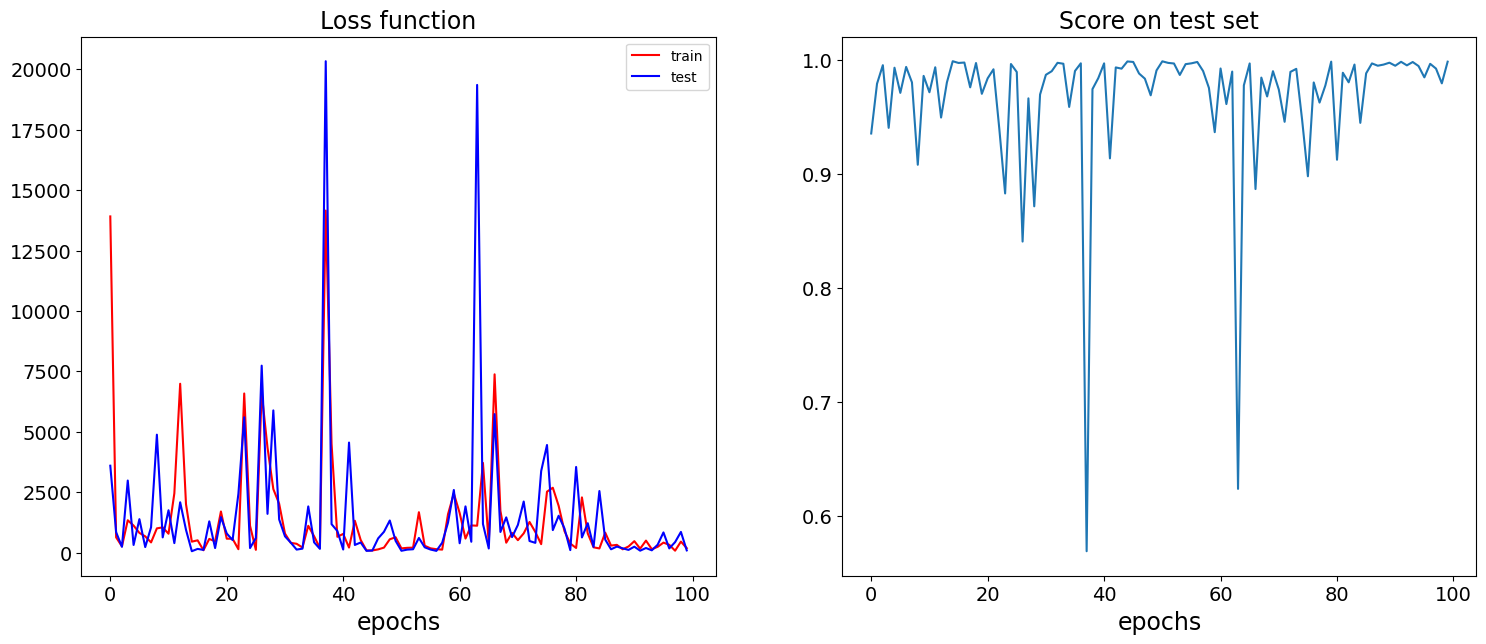

In [31]:
plot_results(train_loss, test_loss, test_score)

## 2. Non-classic MSE (loss function) with classic optimizers
At this topic we try to use non-classic MSE loss function (see image below) when training a simple model


![new loss](../report/new_loss.png)

To use it feature we need to change BATCH_SIZE (should be equal to number of neurons in the first layer)

In [32]:
train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=NUMBER_OF_FEATURES)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=NUMBER_OF_FEATURES)
batch_example_features, batch_example_labels  = next(iter(train_dataloader))
print('shape of batch: features - {} and labels - {}'.format(batch_example_features.shape, batch_example_labels.shape))

shape of batch: features - torch.Size([10, 10]) and labels - torch.Size([10, 1])


In [33]:
optimizers = [optim.Adam, optim.SGD, optim.Adagrad, optim.RMSprop]
learning_rates = [0.1, 1e-7, 100, 0.1]

# how many epochs need to achieve good score with new loss function
### simple model

In [38]:
for optimizer, lr in zip(optimizers, learning_rates):
    simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

    n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                    optimizer_fn=optimizer,
                                                                    loss_fn=loss_fn,
                                                                    metric_fn=metric_fn,
                                                                    data_train=train_dataloader,
                                                                    data_test=test_dataloader,
                                                                    learning_rate=lr,
                                                                    new_loss=True,
                                                                    current_device=device)
    print(f'{optimizer.__name__} need {n_epochs} epochs to achieve R2-score = {test_score[-1]:.3f}')

Adam need 878 epochs to achieve R2-score = 0.950
SGD need 4 epochs to achieve R2-score = 0.969
Adagrad need 2 epochs to achieve R2-score = 0.967
RMSprop need 272 epochs to achieve R2-score = 0.951


### complex model

In [37]:
for optimizer, lr in zip(optimizers, learning_rates):
    # simple_model = nn.Linear(in_features=10, out_features=1, bias=False)
    simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=15, bias=False),
                                 nn.ReLU(),
                                 nn.Linear(in_features=15, out_features=1, bias=False))

    n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                    optimizer_fn=optimizer,
                                                                    loss_fn=loss_fn,
                                                                    metric_fn=metric_fn,
                                                                    data_train=train_dataloader,
                                                                    data_test=test_dataloader,
                                                                    learning_rate=lr,
                                                                    new_loss=True,
                                                                    current_device=device)
    print(f'{optimizer.__name__} need {n_epochs} epochs to achieve R2-score = {test_score[-1]:.3f}')

Adam need 49 epochs to achieve R2-score = 0.951
SGD need 2 epochs to achieve R2-score = nan
Adagrad need 10001 epochs to achieve R2-score = 0.501
RMSprop need 44 epochs to achieve R2-score = 0.959


Also we can check how many epochs need new optimizer for this task (note: we change batch size)

In [39]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

n_epochs, train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                                optimizer_fn=DREMOptimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.01,
                                                                printed=True,
                                                                current_device=device)
print(f'DREM optimizer need {n_epochs} epochs to achieve R2-score = {test_score[-1]:.3f}')

epoch 1: loss = 2436.988 and score = 0.960
DREM optimizer need 1 epochs to achieve R2-score = 0.960


## 3. More complex model
At this topic we try to train more complex model


## 3.1 Adam

In [22]:
simple_model = nn.Sequential(
    nn.Linear(in_features=10, out_features=15),
    nn.ELU(),
    nn.Linear(in_features=15, out_features=1),
)

n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.Adam,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.1,
                                                                printed=True,
                                                                current_device=device)

print()
print(f'Adam need {n_epochs} epochs for {test_score[-1]:.3f} score')

epoch 1: loss = 336.924 and score = 0.975

Adam need 1 epochs for 0.975 score


## 3.2 SGD

In [23]:
simple_model = nn.Sequential(
    nn.Linear(in_features=10, out_features=15),
    nn.ELU(),
    nn.Linear(in_features=15, out_features=1),
)

n_epochs, train_loss, test_loss, test_score = standard_training(model=simple_model,
                                                                optimizer_fn=optim.SGD,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=0.001,
                                                                printed=True,
                                                                current_device=device)

print()
print(f'SGD need {n_epochs} epochs for {test_score[-1]:.3f} score')

epoch 1: loss = 337.132 and score = 0.975

SGD need 1 epochs for 0.975 score


## 3.3 DREM optimizer

In [44]:
simple_model = nn.Sequential(
    nn.Linear(in_features=10, out_features=45, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=45, out_features=1, bias=False),
)

n_epochs, train_loss, test_loss, test_score = drem_opt_training(model=simple_model,
                                                                optimizer_fn=DREMOptimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                learning_rate=1e-10,
                                                                printed=True,
                                                                current_device=device)

print()
print(f'New optimizer need {n_epochs} epochs for {test_score[-1]:.3f} score')

epoch 1: loss = 60072.883 and score = -0.005
epoch 2: loss = 60048.523 and score = -0.005
epoch 3: loss = 60026.773 and score = -0.004
epoch 4: loss = 60020.352 and score = -0.004
epoch 5: loss = 60018.750 and score = -0.004
epoch 6: loss = 59967.152 and score = -0.003
epoch 7: loss = 59956.578 and score = -0.003
epoch 8: loss = 59940.449 and score = -0.003
epoch 9: loss = 59929.070 and score = -0.003
epoch 10: loss = 59914.250 and score = -0.003
epoch 11: loss = 59907.219 and score = -0.002
epoch 12: loss = 59877.156 and score = -0.002
epoch 13: loss = 59869.770 and score = -0.002
epoch 14: loss = 59846.723 and score = -0.002
epoch 15: loss = 59835.516 and score = -0.001
epoch 16: loss = 59830.715 and score = -0.001
epoch 17: loss = 59829.641 and score = -0.001
epoch 18: loss = 59829.027 and score = -0.001
epoch 19: loss = 59825.965 and score = -0.001
epoch 20: loss = 59821.406 and score = -0.001
epoch 21: loss = 59815.750 and score = -0.001
epoch 22: loss = 59810.469 and score = -0.0